"flowchart" per l'applicazione.

1. lettura e preprocessing dei dati
2. lavorazione sul modello
3. generazione output 
4. valutazione output

In [18]:
# packages
import pandas as pd
import numpy as np

from claspy.segmentation import BinaryClaSPSegmentation

import ruptures as rpt

import stumpy
from aeon.segmentation import find_dominant_window_sizes

from aeon.segmentation import GreedyGaussianSegmenter

from aeon.segmentation import InformationGainSegmenter

from aeon.anomaly_detection import STRAY

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, make_scorer,mean_squared_error
import matplotlib.pyplot as plt
from aeon.visualisation import plot_series_with_change_points, plot_series_with_profiles
import seaborn as sns

sns.set_theme()
sns.set_color_codes()

In [19]:
df

,0,1,2,3,4,5,6,7,8,9,10,som
0,0.000000,0.000000,0.000000,0.000000,417.521250,0.000000,0.000000,0.000000,0.000000,0.000000,0.035568,417.556818
1,0.015993,0.263908,0.000000,0.000000,417.443845,0.000000,0.000000,0.000000,0.000000,0.000000,0.035568,417.759314
2,0.030369,0.260064,0.001119,0.000000,417.448940,0.009099,0.006499,0.000008,0.000009,0.000581,0.036587,417.793275
3,0.043534,0.258095,0.003994,0.000000,417.369070,0.022999,0.014315,0.000015,0.000026,0.001688,0.036587,417.750323
4,0.057050,0.223248,0.001761,0.000000,417.310725,0.012820,0.009677,0.000040,0.000100,0.001046,0.036271,417.652738
...,...,...,...,...,...,...,...,...,...,...,...,...
10310,144.102448,0.005549,0.002814,0.727280,540.626719,0.249682,0.489763,0.000052,0.000801,0.006757,0.199974,686.411839
10311,144.114193,0.005784,0.002732,0.730791,540.604337,0.240135,0.429923,0.000094,0.000623,0.006973,0.199974,686.335559
10312,144.127507,0.004429,0.002361,0.734876,540.590764,0.222445,0.372376,0.000180,0.000432,0.006445,0.200141,686.261956
10313,144.139577,0.006367,0.001947,0.738998,540.576683,0.188894,0.322559,0.000243,0.000298,0.005664,0.200141,686.181371


In [20]:
# Questi sono tutte le features estratte
# kineticglobal,kineticchest,directnesshead,density,leftwristke,rightwristke,leftankleke,rightankleke,headke,posturaltension

# Queste sono le feature che utilizzeremo
# kineticglobal, density, leftwirstke, rightwristke, leftankleke, rightankleke, headke, posturaltension
# che corrispondono
# 2,4,5,6,7,8,9,10,11
# Questa funzione legge il file di input e restituisce un dataframe con i dati preprocessati
def ReadAndPreProcess(inputDataRaw):
    # lettura
    df=pd.read_csv(inputDataRaw,sep=' ', header=None)
    df.drop(0, axis=1)
    df["som"]=df.sum(axis=1)
    ## preprocessing

    # dealing NaN values
    #-serafino ha usato forward fill, backward fill, linear interpolation
    #-ricordo che serafino aveva gia utilizzato sta cosa sui dati grezzi non sulle feature ma sui dati prefeature percio dovrebbe essere gia apposto

    # downsampling
    #-sono a 100ms, non sò se devo scendere a 50ms. da decidere

    # low pass filter
    #-Skogstad and colleagues (2013) e https://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    #-implementare dopo

    # remove outliers
    #-utilizzare hampel filter

    # stretch
    #-forse devo stretcharlo come ho fatto precedentemente
    #-anche se nel codice precedente ho stretchato solo il groundtruth

    # ritorno un oggetto dataframe dopo che è stato lavorato, ottenendo un prodotto lavorato
    return df



In [21]:
# questa funzione ritorna un dataframe del groundtruth che viene usato specificatamente per visualizzare il gt
# è soggetto a un preprocessing dei dati siccome l'ultimo groundtruth è dove termina il ts del gt
# di conseguenza per farlo corrispondere, bisogna stretcharlo
# ma ricordo di aver rifatti i dati nuovi per generare un groundtruth a fine ts, da controllare cosi che non serve stretcharlo?
def LoadingGroundTruth(df,gtraw):
    gt=pd.read_csv(gtraw,sep=' ', header=None)
    gt=gt.iloc[:,0].values
    #stretching dei dati se necessario per farlo corrispondere alla ts dei dati
    stretch_gt = np.array([])
    for idx,i in enumerate(gt):
        relpos = len(df)*i/gt[-1]
        stretch_gt = np.append(stretch_gt,relpos)

    # eliminiamo l'ultimo elemento che è stato annotato solo per delimitare la lunghezza della gt simile alla ts
    return stretch_gt[:-1]

In [22]:
# utilizzo CLASP 
# prende come parametro un dataframe e restituisce il clasp score
# gt e known vengono usati per usare il numero vero di cp se uguale a 1 sennò si cerca di predirlo se il modello lo permette
def GetClasp(df,gt,known):
    #result=np.array([])
    result=np.array([])
    eachresult = []
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):
      
        ts=df.iloc[:,i]

        if known == 1:
            print("knwon!")
            clasp = BinaryClaSPSegmentation(n_segments=len(gt), validation=None)
        else:
            print("unknown!")
            clasp = BinaryClaSPSegmentation(n_estimators=30, distance="znormed_euclidean_distance",early_stopping=False)
            
        found_cps = clasp.fit_predict(ts.values)    

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        # per ogni array di cp di ogni singola feature
        # li unisco in un unico array. in pratica faccio un OR di tutti i cp
        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)
        
        

        
    return result, eachresult, clasp
        
    


In [23]:
# utilizzo BINSEG
def GetBinseg(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):
        
        ts=df.iloc[:,i]
        binseg = rpt.Binseg(model="ar").fit(ts.values)

        if known == 1:
            found_cps = np.array(binseg.predict(n_bkps=len(gt)), dtype=np.int64)
        else:
            found_cps = np.array(binseg.predict(pen=np.log(len(ts.values))), dtype=np.int64)
        
        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)

        

    return result, eachresult

In [24]:
#utilizzo WINDOW
def GetWindowSlide(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):
        
        ts=df.iloc[:,i]
        binseg = rpt.Window(model="ar").fit(ts.values)

        if known==1:
            found_cps = np.array(binseg.predict(n_bkps=len(gt)), dtype=np.int64)
        else:
            found_cps = np.array(binseg.predict(pen=np.log(len(ts.values))), dtype=np.int64)
        
        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)

       

    return result, eachresult

In [25]:
# utilizzo FLUSS
def GetFluss(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx, i in enumerate([2,4,5,6,7,8,9,10,11]):

        ts=df.iloc[:,i]
        window_size = min(find_dominant_window_sizes(ts.values) * 2, len(ts.values) // 2)
        mp = stumpy.stump(ts.values, m=window_size)

        if known == 1:
            cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=len(gt))
        else:
            cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=4)
        
        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)

       

    return result, eachresult

In [26]:
# utilizzo GSS
def GetGSS(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):

        ts=df.iloc[:,i]
        
        if known==1:
            ggs = GreedyGaussianSegmenter(k_max=len(gt))
        else:
            ggs = GreedyGaussianSegmenter(k_max=1)


        ggs.fit_predict(ts.values)
        found_cps = ggs.change_points_

        if (len(found_cps) >= 2):
            # remove start and end of the series
            found_cps = found_cps[1:-1] 

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)

  
        
    return result,eachresult

In [27]:
# utilizzo IGS
def GetIGS(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):

        ts=df.iloc[:,i]

        if known==1:
            igts = InformationGainSegmenter(k_max=len(gt))
        else:
            igts = InformationGainSegmenter(k_max=1)

        igts.fit_predict(ts.values)
        found_cps = igts.change_points_

        if (len(found_cps) >= 2):
            # remove start and end of the series
            found_cps = found_cps[1:-1] 

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)


    return result, eachresult
            

In [28]:
#utiizzo STRAY
def GetSTRAY(df,gt,known):
    result=np.array([])
    eachresult=[]
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):

        ts=df.iloc[:,i]
        stray = STRAY()
        stray.fit(ts.values)

        if known==1:
            found_cps = np.sort(np.argpartition(-stray.score_, len(gt))[:len(gt)])
        else:
            found_cps = np.sort(np.argpartition(-stray.score_, 1)[:1])

        if (len(found_cps) >= 2):
            # remove start and end of the series
            found_cps = found_cps[1:-1] 

        # c'è un bug con binseg dove un cp è oltre la lunghezza del ts
        # faccio un loop e se eccede cambio il valore con la len(tf)-1
        for i in range(0,len(found_cps)):
            if found_cps[i] >= len(ts):
                found_cps[i] = len(ts)-1

        result = np.sort(np.append(result,found_cps).flatten())
        result = np.unique(result)
        eachresult.append(found_cps)



    return result, eachresult


In [29]:
def fakeplot(df,gt,cp):
    _ = plot_series_with_change_points(df.iloc[:,7], cp[4], title="prediction number: "+str(7))

    plt.figure(figsize=(18,9))
    plt.plot(np.arange(len(df[7].values)),df[7].values,'blue',linewidth=0.5)
    for idx2,j in enumerate(gt.astype(int)):

        plt.axvline(x = j, color = 'green',linewidth=1) 

In [30]:
def PlotResult(df,gt,cp,eachcp,ts):
    #da testare quando ho piu valori
    #clasp.plot(gt_cps=gt.astype(int), heading="Segmentation of different umpire cricket signals", ts_name="ACC", file_path="segmentation_example.png")

        
    for idx,i in enumerate([2,4,5,6,7,8,9,10,11]):
  
        # idx == 8 è l'ultimo elemento. percio quando i è uguale a 11
        # significa che l'ultimo elemento del mio for è la ts totale di tutte le feature
        if idx == 8:
            plt.figure(figsize=(18,9))
            plt.plot(np.arange(len(df["som"].values)),df["som"].values,'blue',linewidth=0.5)
            for idx2,j in enumerate(gt.astype(int)):

                plt.axvline(x = j, color = 'green',linewidth=1) 

            for j in cp.tolist():
                plt.axvline(x = j, color = 'black',linewidth=1) 
        else:


            print("asd"+str(i))
            _ = plot_series_with_change_points(df.iloc[:,i], eachcp[idx], title=str(ts)+"prediction number: "+str(i))
            for idx2,j in enumerate(gt.astype(int)):
                plt.axvline(x = j, color = 'green',linewidth=1) 

   


In [31]:
# calcola i vari scores dati il groundtruth e il prediction
# puo salvare il risultato su file per evitare di perderli
# prende come parametro nome del groundtruth, groundtruth, nome della timeseries e il prediction
def Evaluate(modelName,gtName, gt, tsName, cp, df):
    # creo dei array di lunghezza come la ts cosi possono fare il confronto
    # sia per il gt che per il pd
  
    cpnump = np.array(cp)
    gtnump = np.array(gt)

    cp_long = np.zeros(len(df)+1)
    cp_long[cpnump.astype(int)]=1

    gt_long = np.zeros(len(df)+1)
    gt_long[gtnump.astype(int)]=1

    accuracy = accuracy_score(gt_long, cp_long)
    precision = precision_score(gt_long,cp_long)
    recall = recall_score(gt_long,cp_long)
    f1 = f1_score(gt_long,cp_long)
    print(f'accuracy, precision, recall, f1: {accuracy,precision,recall,f1}')
    
    #scrivo su file il risultato
    f = open("outputFile/"+str(modelName), "a")
    f.write("model:"+str(tsName)+"\n")
    f.write("Timeseries:"+str(tsName)+" accuracy:"+str(accuracy)+" precision:"+str(precision)+" recall:"+str(recall)+" f1:"+str(f1)+" \n")
    f.write("\n")
    f.close()

In [32]:
#questi sono i dataset comprendente le timeseries e il groundtruth
timeseries=[#"in\cora1_input.txt",
      #"in\cora4_input.txt",
    #"in\cora1_input.txt",
    #  "in\cora4_input.txt",
      "in\cora5_input.txt",
      #"in\cora14_input.txt",
     # "in\cora14_input.txt",
      "in\marianne7_input.txt",
      "in\marianne8_input.txt",
      "in\marianne10_input.txt",
      "in\marianne18_input.txt",
      "in\marianne19_input.txt",
      "in\marianne24_input.txt",
      "in\marianne26_input.txt",
      "in\marianne41_input.txt",
      "in\marianne42_input.txt",
      "in\marianne43_input.txt",
      "in\marianne47_input.txt",
      #"in\marianne48_input.txt",
   #   "in\marianne48_input.txt",
      "in\muriel18_input.txt",
      "in\muriel26_input.txt",
      "in\muriel27_input.txt",
      #"in\muriel30_input.txt"
     # "in\muriel30_input.txt"
      ]
groundtruth=[#"gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
          #  "gt\cora_gt_2019-08-08_t001_video01.txt",
         #"gt\cora_gt_2019-08-08_t004_video01.txt",
         "gt\cora5_gt.txt",
         "gt\cora_gt_2019-08-08_t014_video01.txt",
         "gt\marianne_gt_2016-03-22_t007_video01.txt",
         "gt\marianne_gt_2016-03-22_t008_video01.txt",
         "gt\marianne_gt_2016-03-22_t010_video01.txt",
         "gt\marianne_gt_2016-03-22_t018_video01.txt",
         "gt\marianne_gt_2016-03-22_t019_video01.txt",
         "gt\marianne_gt_2016-03-22_t024_video01.txt",
         "gt\marianne_gt_2016-03-22_t026_video01.txt",
         "gt\marianne_gt_2016-03-22_t041_video01.txt",
         "gt\marianne_gt_2016-03-22_t042_video01.txt",
         "gt\marianne_gt_2016-03-22_t043_video01.txt",
         "gt\marianne_gt_2016-03-22_t047_video01.txt",
         #"gt\marianne_gt_2016-03-22_t048_video01.txt",
       #  "gt\marianne_gt_2016-03-22_t048_video01.txt",
         "gt\muriel_gt_2016-03-21_t014_video01.txt",
         "gt\muriel_gt_2016-03-21_t018_video01.txt",
         "gt\muriel_gt_2016-03-21_t026_video01.txt",
         "gt\muriel_gt_2016-03-21_t027_video01.txt",
         "gt\muriel_gt_2016-03-23_t029_video01.txt",
         #"gt\muriel_gt_2016-03-23_t030_video01.txt",
        # "gt\muriel_gt_2016-03-23_t030_video01.txt"
         ]



# CLASP with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("CLASPk",groundtruth[i],gt,timeseries[i],cp,df)

unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
unknown!
asd2
asd4
asd5
asd6
asd7
asd8
asd9
asd10
accuracy, precision, recall, f1: (0.9905001938735944, 0.0, 0.0, 0.0)


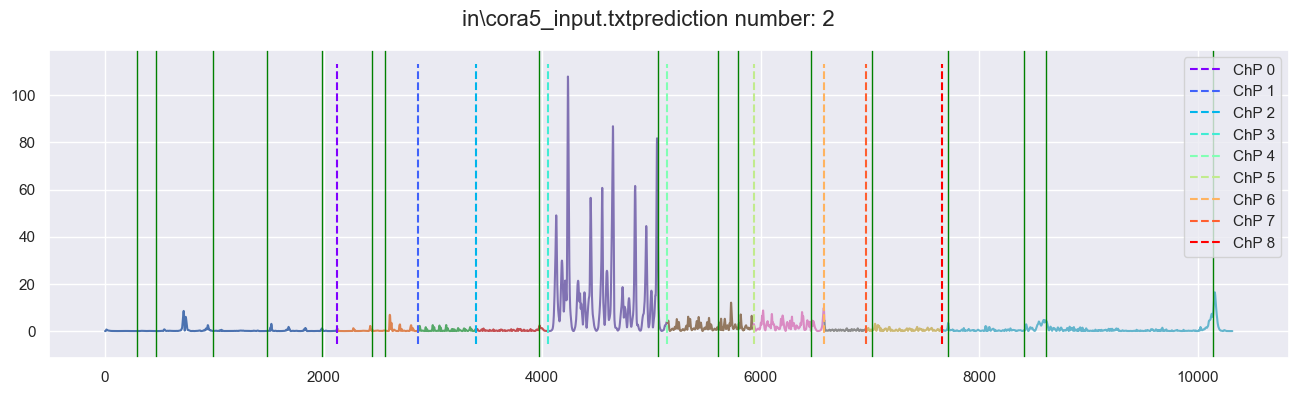

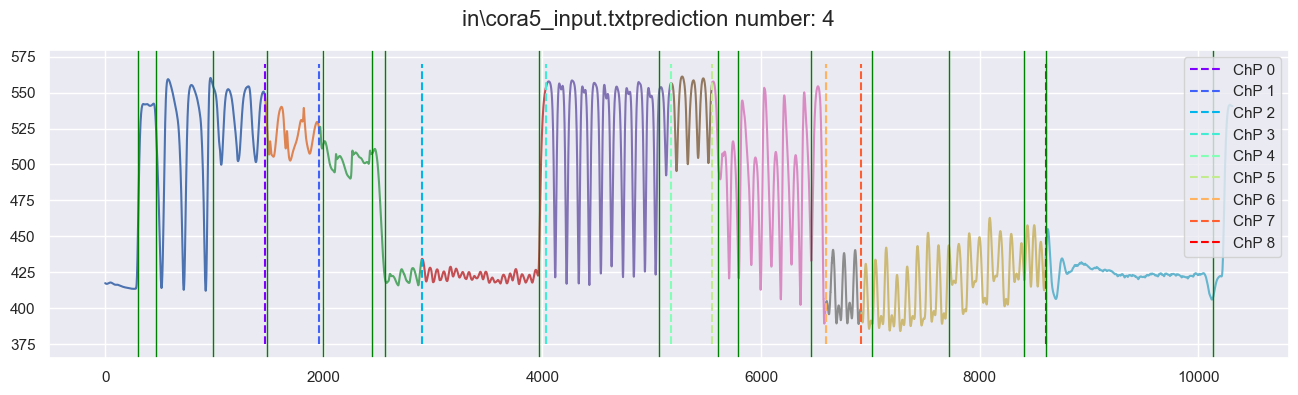

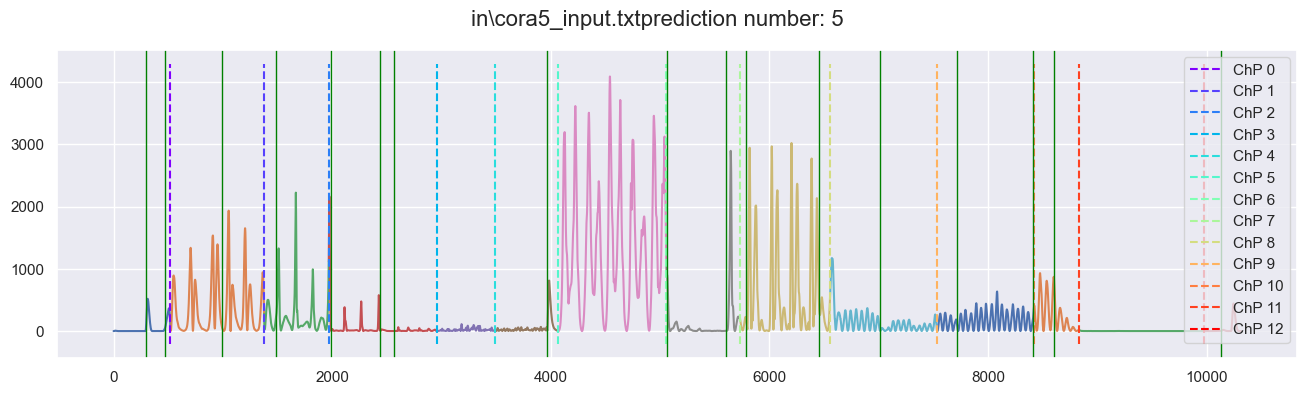

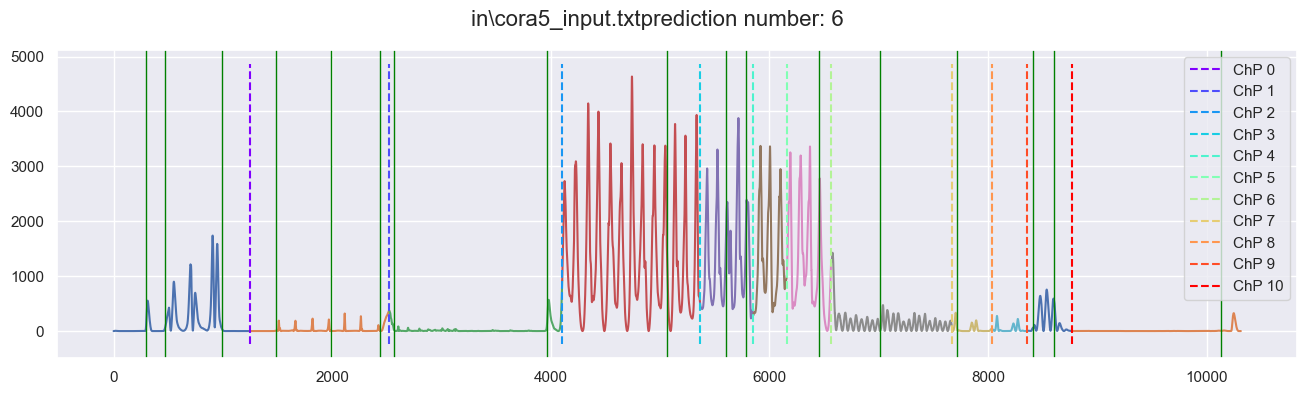

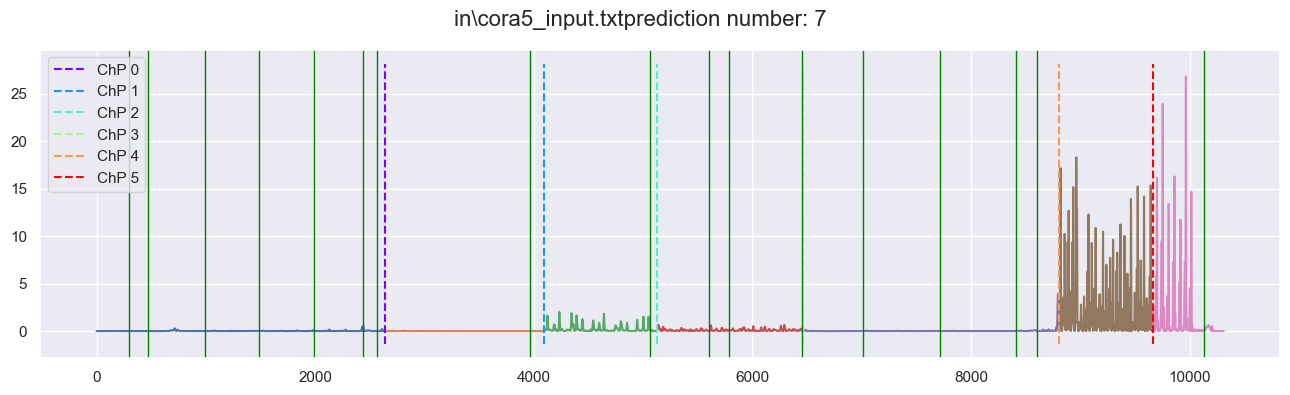

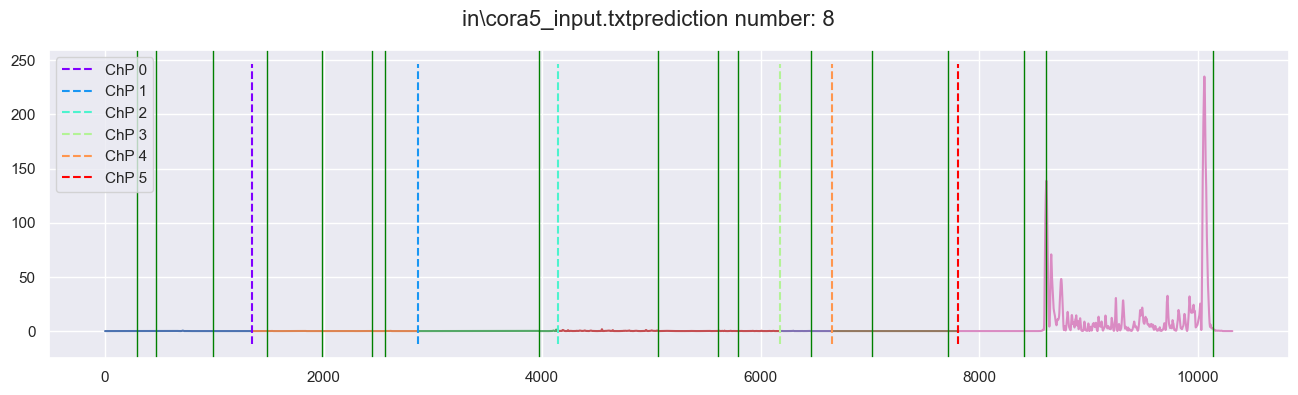

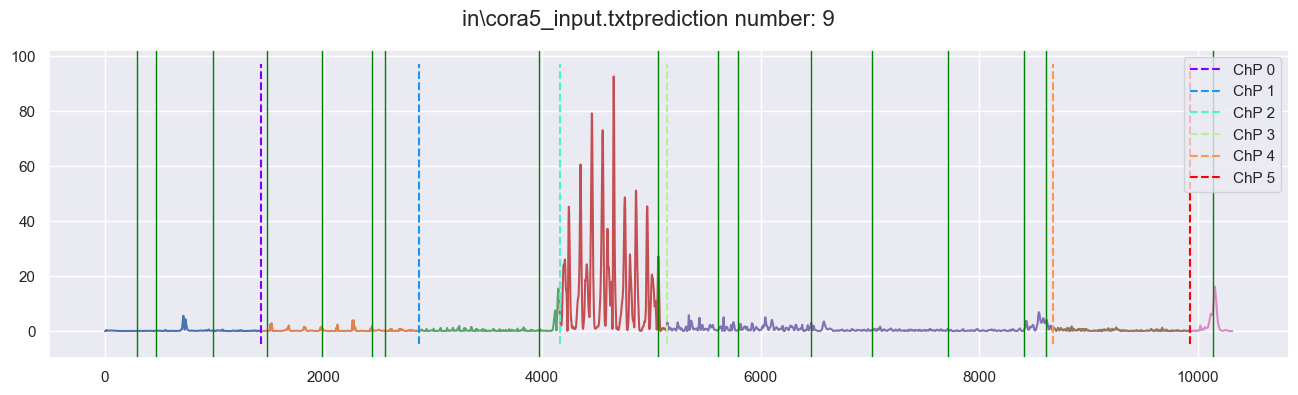

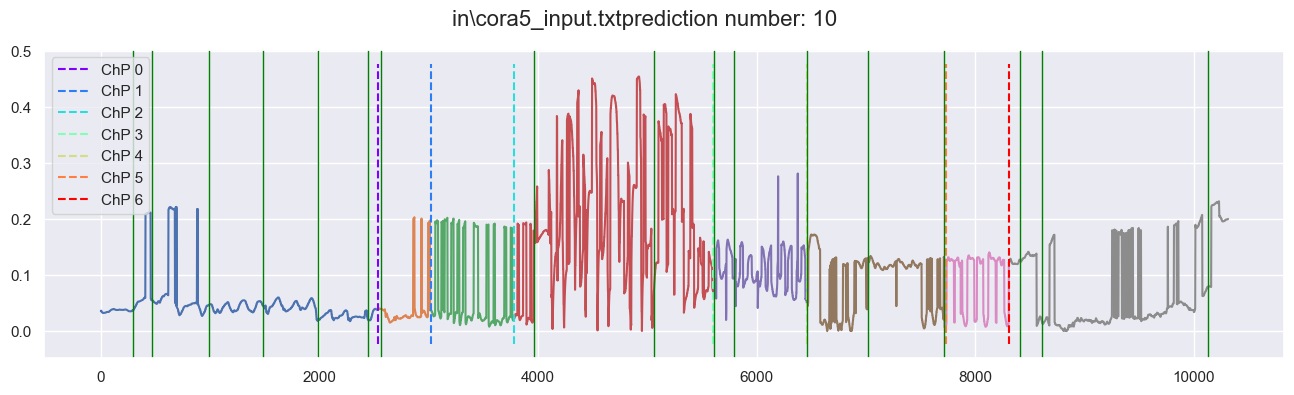

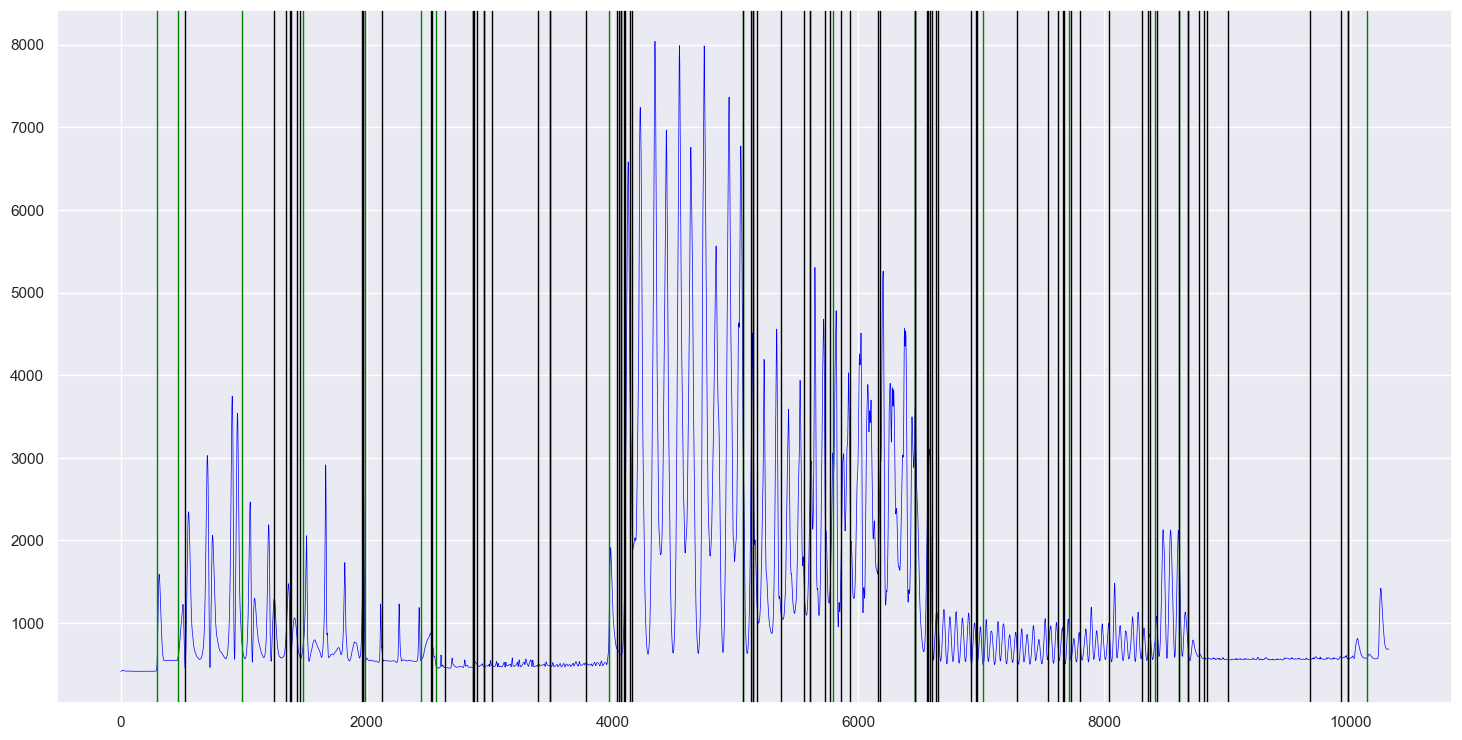

In [33]:
# CLASP without knowing cp
for i in range(0,1):#len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp,clasp=GetClasp(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("CLASP",groundtruth[i],gt,timeseries[i],cp,df)

# BINSEG with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetBinseg(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("BINSEGw",groundtruth[i],gt,timeseries[i],cp,df)

# BINSEG without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetBinseg(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("BINSEG",groundtruth[i],gt,timeseries[i],cp,df)

# WINDOWSLIDE with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetWindowSlide(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("WINDOWw",groundtruth[i],gt,timeseries[i],cp,df)

# WINDOWSLIDE without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetWindowSlide(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("WINDOW",groundtruth[i],gt,timeseries[i],cp,df)

# FLUSS with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetFluss(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("FLUSSw",groundtruth[i],gt,timeseries[i],cp,df)

# FLUSS without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetFluss(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("FLUSS",groundtruth[i],gt,timeseries[i],cp,df)

I MODELLI SOTTO NO XK SERVONO DATI MULTIVARIABILI E I MIEI SONO SINGOLI

# GSS with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetGSS(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("GSSw",groundtruth[i],gt,timeseries[i],cp,df)

# GSS without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetGSS(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("GSS",groundtruth[i],gt,timeseries[i],cp,df)

# IGS with known number of cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetIGS(df,gt,1)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("IGSw",groundtruth[i],gt,timeseries[i],cp,df)

# IGS without knowing cp
for i in range(0,len(timeseries)):
    df=ReadAndPreProcess(timeseries[i])
    gt=LoadingGroundTruth(df,groundtruth[i])
    cp,eachcp=GetIGS(df,gt,0)
    PlotResult(df,gt,cp,eachcp,timeseries[i])
    Evaluate("IGS",groundtruth[i],gt,timeseries[i],cp,df)